# TP 2-3 : Branch-and-bound applied to a knapsack problem

### Initialisation (à faire une seule fois)

In [1]:
import Pkg; 
Pkg.add("GraphRecipes"); Pkg.add("Plots"); 
using GraphRecipes, Plots #only used to visualize the search tree at the end of the branch-and-bound

    Updating registry at `~/.julia/registries/General.toml`


   Resolving 

package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


### Récupération des données

In [2]:
function readKnaptxtInstance(filename)
    price=[]
    weight=[]
    KnapCap=[]
    open(filename) do f
        for i in 1:3
            tok = split(readline(f))
            if(tok[1] == "ListPrices=")
                for i in 2:(length(tok)-1)
                    push!(price,parse(Int64, tok[i]))
                end
            elseif(tok[1] == "ListWeights=")
                for i in 2:(length(tok)-1)
                    push!(weight,parse(Int64, tok[i]))
                end
            elseif(tok[1] == "Capacity=")
                push!(KnapCap, parse(Int64, tok[2]))
            else
                println("Unknown read :", tok)
            end 
        end
    end
    capacity=KnapCap[1]
    return price, weight, capacity
end

readKnaptxtInstance (generic function with 1 method)

### Tests de sondabilités TA, TO et TR basés sur le modèle linéaire

In [3]:


function TestsSondabilite_LP(x, objectiveFunc, BestProfit, Bestsol, bTA)
    TA, TO, TR = false, false, false
    d = zeros(length(x))
    roundbin = zeros(length(x))
    diffabs = zeros(length(x))
    bTR = false
    for i = 1:length(x)
        #if (x[i] != 0) && (x[i] != 1)
           # bTR = false
          #  break
       # end
        roundbin[i] = round(x[i], digits = 0)
        diffabs[i] = abs(roundbin[i]-x[i])
    end

    if bTA #Test de faisabilite
        TA=true
        println("TA")
    elseif(objectiveFunc(x) <= BestProfit) #Test d'optimalite
        TO=true
        println("TO")
    elseif sum(diffabs) <= 10^-5  
         #Test de resolution
        TR=true
        println("TR")
        #if (value(benef) >= BestProfit)
        if (objectiveFunc(x) >= BestProfit)
            Bestsol = x
            #BestProfit=value(benef)
            BestProfit=objectiveFunc(x)
            println("\nNew Solution memorized ", Bestsol, " with bestprofit ", BestProfit, "\n")
        end
    else
        println("non sondable")
    end
    TA, TO, TR, Bestsol, BestProfit
end

     


TestsSondabilite_LP (generic function with 1 method)

## Procédure de séparation (branching) et stratégie d'exploration permettant de se placer au prochain noeud à traiter

In [4]:


function SeparerNoeud_lexicographic_depthfirst!(listobjs, listvals, n)
    # this node is non-sondable. Apply the branching criterion to separate it into two subnodes
    # and choose the child-node at the left  
    
    # lexicographic branching criterion: branch on the 1st object not yet fixed
    i, obj = 1, 0
    while((i <= n) && (obj==0))
        if(!(i in listobjs))
            obj=i
        end
        i+=1
    end
    
    println("\nbranch on object ", obj, "\n")

    # depthfirst exploration strategy: the node selected will be the most left of the child-nodes just created
    push!(listobjs,obj) #save the identity of the object selected for branching
    push!(listvals,1.0) #save the node selected, identified by the value assigned to the variable/object chosen
end


function ExplorerAutreNoeud_depthfirst!(listobjs, listvals, listnodes)
    #this node is sondable, go back to parent node then right child if possible
    
    stop=false
    #check if we are not at the root node
    if (length(listobjs)>= 1)
        #go back to parent node
        obj=pop!(listobjs)
        theval=pop!(listvals)
        tmp=pop!(listnodes)

        #go to right child if possible, otherwise go back to parent
        while( (theval==0.0) && (length(listobjs)>= 1))
            obj=pop!(listobjs)
            theval=pop!(listvals)
            tmp=pop!(listnodes)
        end
        if theval==1.0
            push!(listobjs,obj)
            push!(listvals,0.0)
        else
            println("\nFINISHED")
            stop=true
        end
    else
        #the root node was sondable
        println("\nFINISHED")
        stop=true
    end
    return stop 
end

ExplorerAutreNoeud_depthfirst! (generic function with 1 method)

###  Création de la relaxation linéaire (= modèle associé au noeud 0): <span style="color:red"> SECTION A SUPPRIMER !!!! </span>

<span style="color:red"> Cette section est à commenter/supprimer et remplacer par vos propres calculs de bornes supérieures et autres, par exemple basées sur les bornes 1 et 2 vues en cours, ou d'autres calculs de bornes de votre choix/conception validés au préalable par votre encadrant/e de TP </span>

In [5]:
Pkg.add("Clp");
Pkg.add("JuMP");
using JuMP, Clp
using Statistics

#function MajModele_LP!(model2, x, listobjs, listvals)
#    for i in 1:length(listobjs)
#        set_lower_bound(x[listobjs[i]],listvals[i])
#        set_upper_bound(x[listobjs[i]],listvals[i])
#    end
#end

#function Reset_LP!(model2, x, listobjs)
#    for i in 1:length(listobjs)
#        set_lower_bound(x[listobjs[i]],0.0)
#        set_upper_bound(x[listobjs[i]],1.0)
#    end
#end

#function Reset_allLP!(model2, x)
#    for i in 1:length(x)
#        set_lower_bound(x[i],0.0)
#        set_upper_bound(x[i],1.0)
#    end
#end

#function CreationModele_LP(price, weight, capacity)
# ROOT NODE
    
#   n=length(price)
    
#    model2 = Model(Clp.Optimizer) # set optimizer
#    set_optimizer_attribute(model2, "LogLevel", 0) #don't display anything during solve
#    set_optimizer_attribute(model2, "Algorithm", 4) #LP solver chosen is simplex

    # define x variables as CONTINUOUS (recall that it is not possible to define binary variables in Clp)
#    @variable(model2, 0 <= x[i in 1:n] <= 1)

    # define objective function
#    @objective(model2, Max, sum(price[i]*x[i] for i in 1:n))

    # define the capacity constraint 
  #  @constraint(model2, sum(weight[i]*x[i] for i in 1:n) <=  capacity)

 #   println(model2) 

   # return model2, x
#end

#m,v = CreationModele_LP([40;42;12;25],[7;4;3;5],10)

function CalculateBorne1(capacity, price, weight, listobjs, listvals, r_trie)
    
    s = zeros(length(price))      #vecteur solution du PSF
    TA = false                
    LeftCapacity = capacity
    borne1 = 0
    r = zeros(length(price))      #vecteur des ratios
    # calcul des ratios
    for i in 1:length(price)
        r[i] = price[i] / weight[i]
    end
    for i in 1:length(listobjs)
        j = listobjs[i]
        s[j] = listvals[i]
        LeftCapacity -= listvals[i]*weight[j] 
    end
    if LeftCapacity < 0
        TA = true
    else
        i = r_trie[1]
        s[i] = LeftCapacity/weight[i]
        borne1 = LeftCapacity*r[i]
    end
    return s,borne1,TA
end

function CalculateBorne2(capacity, price, weight, listobjs, listvals, r_trie)
    LeftCapacity = capacity
    s = zeros(length(price))      #vecteur solution du PSF
    
    TA = false
    b2 = 0         
    k = 1                

    

    #
    for i in 1:length(listobjs)
        j = listobjs[i]
        s[j] = listvals[i]
        b2 += listvals[i]*price[j]
        LeftCapacity -= listvals[i]*weight[j] 
    end 
    if LeftCapacity < 0
        TA = true
    end
    
    while LeftCapacity > 0 && (k<= length(price))
        i = r_trie[k]
        if !(i in listobjs)
            if (LeftCapacity < weight[i])
                s[i] = LeftCapacity/weight[i]
                LeftCapacity = LeftCapacity - s[i]*weight[i]
                    
            else
                s[i] = 1
                LeftCapacity = LeftCapacity - weight[i]
            end
            b2 += s[i]*price[i]
            
        end
        k+=1
        
    end
    
    return s,b2,TA
end


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


CalculateBorne2 (generic function with 1 method)

### Boucle principale : résoudre une relaxation, appliquer les tests de sondabilité, identifier le prochain noeud, répéter.

## Avec la borne 2:

In [11]:

function SolveKnapInstance(filename)

    #price, weight, capacity = readKnaptxtInstance(filename)
    price, weight, capacity =[42,40,12,25,13,23],[7,4,3,5,6,8],16
    s = zeros(length(price))
    borne = 0
    TA = false
    objective(x) = sum(x[i]*price[i] for i = 1:length(x))
    r = zeros(length(price))      #vecteur des ratios
    # calcul des ratios
    for i in 1:length(price)
        r[i] = price[i] / weight[i]
    end
    r_trie = sortperm(r, rev = true)

    #create the structure to memorize the search tree for visualization at the end
    trParentnodes=Int64[] #will store orig node of arc in search tree
    trChildnodes=Int64[] #will store destination node of arc in search tree
    trNamenodes=[] #will store names of nodes in search tree

    #intermediate structure to navigate in the search tree
    listobjs=[]
    listvals=[]
    listnodes=[]

    BestProfit=-1
    Bestsol=[]

    current_node_number=0
    stop = false

    while(!stop)

        println("\nNode number ", current_node_number, ": \n---------------\n")

        #Update the graphical tree
        push!(trNamenodes,current_node_number+1) 
        if(length(trNamenodes)>=2)
            push!(trParentnodes,listnodes[end]+1) # +1 because the 1st node is "node 0"
            push!(trChildnodes, current_node_number+1) # +1 because the 1st node is "node 0"
        end
        push!(listnodes, current_node_number)
        
        #create LP of current node
        # MajModele_LP!(model2, x, listobjs, listvals)
        
        #println(model2)
        
        #print("Solve the LP model of the current node to compute its bound: start ... ")

        #status = optimize!(model2)

        #println("... end"); 

        #print(": Solution LP")
        #if(termination_status(model2) == MOI.INFEASIBLE)#(has_values(model2))
         #   print(" : NOT AVAILABLE (probably infeasible or ressources limit reached)")
        #else
         #   print(" ", objective_value(model2))
          #  [print("\t", name(v),"=",value(v)) for v in all_variables(model2)] 
        #end
        #println(" "); 
        
            
        s,borne,TA = CalculateBorne2(capacity,price,weight,listobjs,listvals,r_trie)
        #println("\nPrevious Solution memorized ", Bestsol, " with bestprofit ", BestProfit, "\n")
        println(s)
        println(r)
        TA, TO, TR, Bestsol, BestProfit = TestsSondabilite_LP(s, objective, BestProfit, Bestsol, TA)

        is_node_sondable = TA || TO || TR

        #Reset_LP!(model2, x, listobjs)

        if(!is_node_sondable)
            SeparerNoeud_lexicographic_depthfirst!(listobjs, listvals, length(s))
        else
            stop = ExplorerAutreNoeud_depthfirst!(listobjs, listvals, listnodes)
        end
        
        #Reset_allLP!(model2, x)

        current_node_number = current_node_number + 1
    end

    #println("\n******\n\nOptimal value = ", BestProfit, "\n\nOptimal x=", Bestsol)

    return BestProfit, Bestsol, trParentnodes, trChildnodes, trNamenodes

end


SolveKnapInstance (generic function with 1 method)

## Avec la borne 1:

In [7]:
function SolveKnapInstance2(filename)

    
    price, weight, capacity = readKnaptxtInstance(filename)
    s = zeros(length(price))
    borne = 0
    TA = false
    objective(x) = sum(x[i]*price[i] for i = 1:length(x))
    r = zeros(length(price))      #vecteur des ratios
    # calcul des ratios
    for i in 1:length(price)
        r[i] = price[i] / weight[i]
    end
    r_trie = sortperm(r, rev = true)

    #create the structure to memorize the search tree for visualization at the end
    trParentnodes=Int64[] #will store orig node of arc in search tree
    trChildnodes=Int64[] #will store destination node of arc in search tree
    trNamenodes=[] #will store names of nodes in search tree

    #intermediate structure to navigate in the search tree
    listobjs=[]
    listvals=[]
    listnodes=[]

    BestProfit=-1
    Bestsol=[]

    current_node_number=0
    stop = false

    while(!stop)

        println("\nNode number ", current_node_number, ": \n---------------\n")

        #Update the graphical tree
        push!(trNamenodes,current_node_number+1) 
        if(length(trNamenodes)>=2)
            push!(trParentnodes,listnodes[end]+1) # +1 because the 1st node is "node 0"
            push!(trChildnodes, current_node_number+1) # +1 because the 1st node is "node 0"
        end
        push!(listnodes, current_node_number)
        
        #create LP of current node
        # MajModele_LP!(model2, x, listobjs, listvals)
        
        #println(model2)
        
        #print("Solve the LP model of the current node to compute its bound: start ... ")

        #status = optimize!(model2)

        #println("... end"); 

        #print(": Solution LP")
        #if(termination_status(model2) == MOI.INFEASIBLE)#(has_values(model2))
         #   print(" : NOT AVAILABLE (probably infeasible or ressources limit reached)")
        #else
         #   print(" ", objective_value(model2))
          #  [print("\t", name(v),"=",value(v)) for v in all_variables(model2)] 
        #end
        #println(" "); 
        
            
        s,borne,TA = CalculateBorne1(capacity,price,weight,listobjs,listvals,r_trie)
        #println("\nPrevious Solution memorized ", Bestsol, " with bestprofit ", BestProfit, "\n")
        
        TA, TO, TR, Bestsol, BestProfit = TestsSondabilite_LP(s, objective, BestProfit, Bestsol, TA)

        is_node_sondable = TA || TO || TR

        #Reset_LP!(model2, x, listobjs)

        if(!is_node_sondable)
            SeparerNoeud_lexicographic_depthfirst!(listobjs, listvals, length(s))
        else
            stop = ExplorerAutreNoeud_depthfirst!(listobjs, listvals, listnodes)
        end
        
        #Reset_allLP!(model2, x)

        current_node_number = current_node_number + 1
    end

    #println("\n******\n\nOptimal value = ", BestProfit, "\n\nOptimal x=", Bestsol)

    return BestProfit, Bestsol, trParentnodes, trChildnodes, trNamenodes

end

SolveKnapInstance2 (generic function with 1 method)

In [13]:
BestProfit, BestSol, trParentnodes, trChildnodes, trNamenodes = SolveKnapInstance("instancesETU/KNAPnewformat/circle/knapPI_16_20_1000_1_-2291.opb.txt")
println("\n******\n\nOptimal value = ", BestProfit, "\n\nOptimal x=", BestSol)


Node number 0: 
---------------

[1.0, 1.0, 0.0, 1.0, 0.0, 0.0]
[6.0, 10.0, 4.0, 5.0, 2.1666666666666665, 2.875]
TR

New Solution memorized [1.0, 1.0, 0.0, 1.0, 0.0, 0.0] with bestprofit 107.0


FINISHED

******

Optimal value = 107.0

Optimal x=[1.0, 1.0, 0.0, 1.0, 0.0, 0.0]


### Affichage du résultat final


Node number 0: 
---------------

[0.8571428571428571, 1.0, 0.0, 0.0]
[6.0, 10.0, 4.0, 5.0]
non sondable

branch on object 1


Node number 1: 
---------------

[1.0, 0.75, 0.0, 0.0]
[6.0, 10.0, 4.0, 5.0]
non sondable

branch on object 2


Node number 2: 
---------------

[1.0, 1.0, 0.0, 0.0]
[6.0, 10.0, 4.0, 5.0]
TA

Node number 3: 
---------------

[1.0, 0.0, 0.0, 0.6]
[6.0, 10.0, 4.0, 5.0]
non sondable

branch on object 3


Node number 4: 
---------------

[1.0, 0.0, 1.0, 0.0]
[6.0, 10.0, 4.0, 5.0]
TR

New Solution memorized [1.0, 0.0, 1.0, 0.0] with bestprofit 54.0


Node number 5: 
---------------

[1.0, 0.0, 0.0, 0.6]
[6.0, 10.0, 4.0, 5.0]
non sondable

branch on object 4


Node number 6: 
---------------

[1.0, 0.0, 0.0, 1.0]
[6.0, 10.0, 4.0, 5.0]
TA

Node number 7: 
---------------

[1.0, 0.0, 0.0, 0.0]
[6.0, 10.0, 4.0, 5.0]
TO

Node number 8: 
---------------

[0.0, 1.0, 0.3333333333333333, 1.0]
[6.0, 10.0, 4.0, 5.0]
non sondable

branch on object 2


Node number 9: 
----------

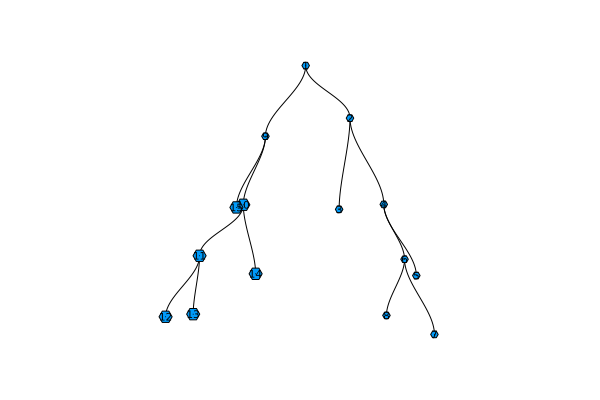

In [9]:
BestProfit, Bestsol, trParentnodes, trChildnodes, trNamenodes = SolveKnapInstance("instancesETU/KNAPnewformat/test.opb.txt")
println("\n******\n\nOptimal value = ", BestProfit, "\n\nOptimal x=", Bestsol)
graphplot(trParentnodes, trChildnodes, names=trNamenodes, method=:tree)

In [10]:
BestProfit, Bestsol, trParentnodes, trChildnodes, trNamenodes = SolveKnapInstance2("instancesETU/KNAPnewformat/test.opb.txt")
println("\n******\n\nOptimal value = ", BestProfit, "\n\nOptimal x=", Bestsol)
graphplot(trParentnodes, trChildnodes, names=trNamenodes, method=:tree)


Node number 0: 
---------------

TR

New Solution memorized [0.0, 4.0, 0.0, 0.0, 0.0, 0.0] with bestprofit 160.0


FINISHED

******

Optimal value = 160.0

Optimal x=[0.0, 4.0, 0.0, 0.0, 0.0, 0.0]


MethodError: MethodError: reducing over an empty collection is not allowed; consider supplying `init` to the reducer

## Questions préliminaires:

1. La règle de séparation utilsée ici consiste à énumérer les objets par ordre croissant 1,2,...etc; de façon à ne se brancher qu'à gauche en donnant 1.0 à la valeur de l'objet.
2. L'algorithme Branch and Bound fourni utilise la fonction optimize du solveur LP.
3. Le test d'admissiblité vérifie le status de terminaison du modèle qui est dans notre problème : vérifier si la capacité restante est négative ou non.
 Le test d'optimalité vérifie si la borne supérieure du noeud est inférieur à la meilleure solution connue.
 Le test de résolution vérifie si la solution est réalisable et dans le cas échéant changer la solution si la borne supérieur du noeud est meilleure que celle considérée au début.
4. On vérifie si un noeud est sondable; si oui, s'il s'agit d'un fils gauche, on revient au noeud parent et on passe au fils droit si possible. 







## Code et analyse:

2. Pour le calcul de la borne 2, on suppose qu'on remplie le sac par tous les objets en ne mettant qu'un seul chacun jusqu'à ce que la capacité restante ne soit pas suffisante d'ajouter un autre objet; dans ce cas on complète par une fraction de l'objet de plus gros ratio.
3. On garde la même règle de séparation et la même stratégie d'exploration. De même pour les tests TA, TO et TR.
4.  On utilise des listes pour stocker les objets (listobjs) et leurs valeurs (listvals) de façon à ce que listobjs stocke dans l'ordre de la mise des objets dans le sac pour la solution et listvals décrit en binaire la présence des objets dans le même ordre que celui de listeobjs.